In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import simpson

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
c = 3 * 1e8  # Speed of light in m/s
eps0 = 8.85 * 1e-12
mu0 = 4 * np.pi * 1e-7  # Permeability of free space (H/m)

In [4]:
# Parametersd
n_sub = 1.5 # Refractive index outside
n_core = 3.5  # Core refractive index
n_clad = 1.5 # Cladding refractive index
d = 0.2e-6  # Thickness in meters
d_coup = 0.6e-6 # Distance between waveguides
wavelength = 1.55e-6  # Wavelength in meters

In [5]:
k0 = 2 * np.pi / wavelength  # Free space wave number
omega = 2 * np.pi * c / wavelength  # Angular frequency

V = k0 * d * np.sqrt(n_core ** 2 - n_clad ** 2)  # Normalized frequency for given parameters
print(f"V = {round(V, 3)}")

V = 2.564


In [6]:
max_modes = int(np.floor(V / np.pi)) + 1  # Number of modes (N=0, 1, 2)
print(f"Number of modes: {max_modes}")
b_te = []
b_tm = []

Number of modes: 1


In [7]:
# Characteristic equations for TE modes
def characteristic_TE(b, V, n_core, n_clad, n_sub, N):
    a = (n_clad ** 2 - n_sub ** 2) / (n_core ** 2 - n_clad ** 2)
    lhs = np.arctan(np.sqrt(max(b, 0) / max(1 - b, 1e-9))) + np.arctan(np.sqrt(max(b + a, 0) / max(1 - b, 1e-9)))
    rhs = V * np.sqrt(max(1 - b, 0)) - np.pi * N
    return lhs - rhs

In [8]:
# Corrected characteristic equation for TM modes
def characteristic_TM(b, V, n_core, n_clad, n_sub, N):
    a = (n_clad ** 2 - n_sub ** 2) / (n_core ** 2 - n_clad ** 2)
    lhs = (np.arctan((n_core**2 / n_clad**2) * np.sqrt(max(b, 0) / max(1 - b, 1e-9))) +
           np.arctan((n_core**2 / n_sub**2) * np.sqrt(max(b + a, 0) / max(1 - b, 1e-9))))
    rhs = V * np.sqrt(max(1 - b, 0)) - np.pi * N
    return lhs - rhs

In [9]:
initial_b = [0.9999999 - N * 0.005 for N in range(max_modes)]

for N in range(max_modes):
    try:
        # Solve for TE modes
        b_te_solution = fsolve(characteristic_TE, initial_b[N], args=(V, n_core, n_clad, n_sub, N))[0]
        if 0 < b_te_solution < 1:
            b_te.append((N, b_te_solution))
        else:
            b_te.append((N, None))

        # Solve for TM modes with corrected equation
        b_tm_solution = fsolve(characteristic_TM, initial_b[N], args=(V, n_core, n_clad, n_sub, N))[0]
        if 0 < b_tm_solution < 1:
            b_tm.append((N, b_tm_solution))
        else:
            b_tm.append((N, None))
    except:
        print(f"Error solving for mode N={N}: {e}")
        b_te.append((N, None))
        b_tm.append((N, None))


In [10]:
# Compute effective indices (n_eff) for each b value
n_eff_te = [np.sqrt(b[1] * (n_core ** 2 - n_clad ** 2) + n_clad ** 2) if b[1] is not None else None for b in
            b_te]
n_eff_tm = [np.sqrt(b[1] * (n_core ** 2 - n_clad ** 2) + n_clad ** 2) if b[1] is not None else None for b in
            b_tm]

In [11]:
# Print results for TE and TM modes
print("TE Modes:")
for N, b, neff in zip(range(max_modes), b_te, n_eff_te):
    print(f"Mode N={N},\t b={b[1]:.5},\tn_eff={neff:.5}")

TE Modes:
Mode N=0,	 b=0.56241,	n_eff=2.8061


In [12]:
print("TM Modes:")
for N, b, neff in zip(range(max_modes), b_tm, n_eff_tm):
    print(f"Mode N={N},\t b={b[1]:.5},\tn_eff={neff:.5}")

TM Modes:
Mode N=0,	 b=0.16119,	n_eff=1.9652


# Symmetric Characteristic Equation and Normalized TE0 Mode

In a symmetric dielectric slab waveguide, the **characteristic equation** for the TE0 mode is:

$$
\frac{1}{2} h d \cdot \tan\left(\frac{h d}{2}\right) = \frac{1}{2} p d
$$

In [13]:
p = lambda beta: np.sqrt(beta**2 - (n_clad * k0)**2)  # Decay constant in cladding
h = lambda beta: np.sqrt((n_core * k0)**2 - beta**2)  # Propagation constant in core

In [14]:
beta = n_eff_te[0] * k0 # Only foundamental mode TE0

# Calculate h and p using beta
h_value = h(beta)
p_value = p(beta)

- **Core** ($0 < x < d$): 
 $$
 E(x) = \cos\left(h \cdot (x - d/2)\right)/\cos\left(h \cdot(d/2\right))
 $$
- **Cladding**:
 $$
 E(x) = 
 \begin{cases} 
 E(0) \cdot e^{p (x - d/2)}, & x < 0 \\
 E(d) \cdot e^{-p (x - d/2)}, & x > d
 \end{cases}
 $$

In [15]:
x = np.linspace(-d, 2 * d, 1000)  # Include regions outside the core
field_profile = np.zeros_like(x)

# Core region (0 < x < d)
core_region = (x >= 0) & (x <= d)
field_profile[core_region] = (
    np.cos(h_value * (x[core_region] - d / 2)) / np.cos(h_value * d / 2)
) * np.exp(-p_value * d / 2) 

left_cladding = x < 0
field_profile[left_cladding] = np.exp(
    p_value * (x[left_cladding] - d / 2)
) 

right_cladding = x > d
field_profile[right_cladding] = np.exp(
    -p_value * (x[right_cladding] - d/2)
) 

In [16]:
dx = x[1] - x[0]
integral = np.sum(np.abs(field_profile)**2) * dx  # Compute the integral of E^2
normalization_factor = np.sqrt(2 * omega * mu0 / beta / integral)
field_profile *= normalization_factor

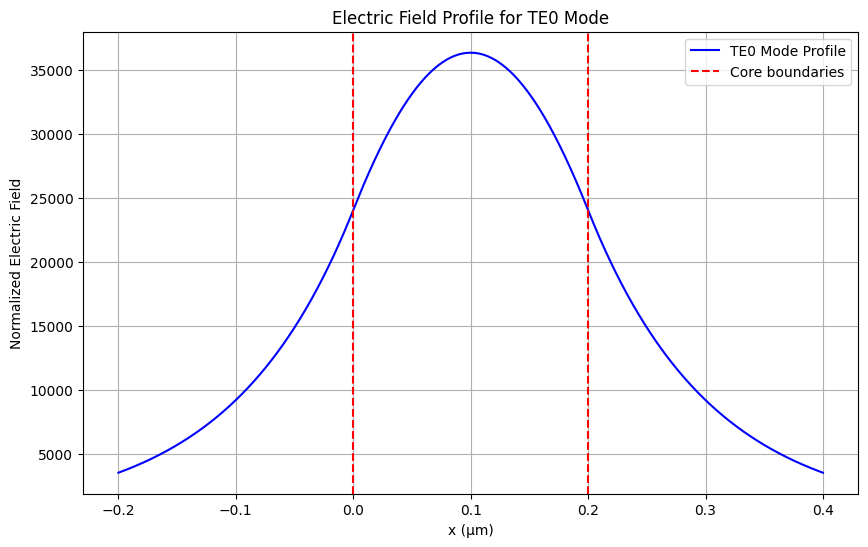

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(x * 1e6, field_profile, label="TE0 Mode Profile", color="blue")
plt.axvline(0, color='red', linestyle='--', label="Core boundaries")
plt.axvline(d * 1e6, color='red', linestyle='--')
plt.title("Electric Field Profile for TE0 Mode")
plt.xlabel("x (µm)")
plt.ylabel("Normalized Electric Field")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def electric_field(x, center, h_value, p_value, d, d_coup):

    E = np.zeros_like(x)

    # Define regions based on the center
    core_region = (x >= center - d / 2) & (x <= center + d / 2)
    left_cladding = x < (center - d / 2)
    right_cladding = x > (center + d / 2)

    # Core Region
    E[core_region] = (
        np.cos(h_value * (x[core_region] - center)) / np.cos(h_value * (d / 2))
    ) * np.exp(-p_value * (d / 2))

    # Left Cladding
    E[left_cladding] = np.exp(p_value * (x[left_cladding] - center))

    # Right Cladding
    E[right_cladding] = np.exp(-p_value * (x[right_cladding] - center))

    # Calculate the integral of |E|^2 for normalization using Simpson's rule
    integral = np.trapz(np.abs(E)**2, x)

    # Calculate the normalization factor
    normalization_factor = np.sqrt(2 * omega * mu0 / beta / integral)

    # Normalize the electric field
    E *= normalization_factor

    return E

In [19]:
center_a = d / 2
center_b = (3 * d + 2 * d_coup) / 2

In [20]:
def E_a(x):
    return electric_field(x,center_a, h_value, p_value, d, d_coup)

def E_b(x):
    return electric_field(x,center_b, h_value, p_value, d, d_coup)

In [21]:
def n_a_squared(x):
    n_a_square = np.zeros_like(x)

    core_region_a = (x >= 0) & (x <= d)
    n_a_square[core_region_a] = n_core**2 - n_clad**2

    return n_a_square

def n_b_squared(x):
    n_b_square = np.zeros_like(x)

    core_region_b = (x >= d + d_coup) & (x <= 2*d + d_coup)
    n_b_square[core_region_b] = n_core**2 - n_clad**2

    return n_b_square

In [22]:
x = np.linspace(-4*d, 4*d + d_coup, 10000)  # Include regions outside the core

integrand_kappa = np.conj(E_a(x)) * n_a_squared(x) * E_b(x)
integrand_kappa1 = np.conj(E_b(x)) * n_b_squared(x) * E_a(x)
integrand_M_aa = np.conj(E_a(x)) * n_b_squared(x) * E_a(x)
integrand_M_bb = np.conj(E_b(x)) * n_a_squared(x) * E_b(x)

In [23]:
kappa = (omega / 4) * eps0 * simpson(integrand_kappa)
M_aa = (omega / 4) * eps0 * simpson(integrand_M_aa)
M_bb = (omega / 4) * eps0 * simpson(integrand_M_bb)
kappa1 = (omega / 4) * eps0 * simpson(integrand_kappa1)

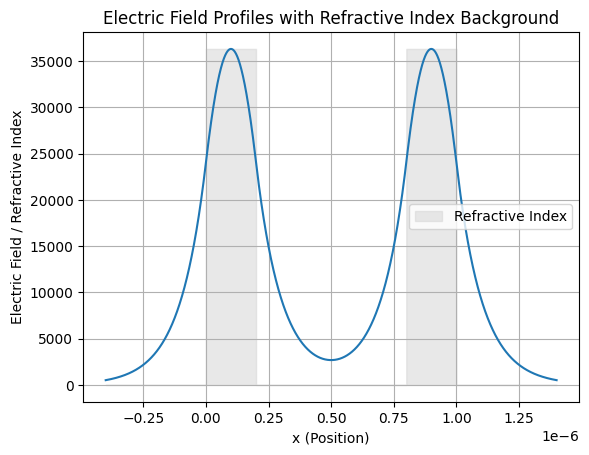

In [24]:
x = np.linspace(-2*d, 4*d + d_coup, 10000)  # Include regions outside the core

field_profile = E_a(x) + E_b(x)
n = n_a_squared(x) + n_b_squared(x)
scale_factor = max(field_profile) / max(n)
n = n * scale_factor

plt.plot(x, field_profile)
# Plot the refractive index profile as a background
plt.fill_between(x, n, color='lightgray', alpha=0.5, label="Refractive Index")

plt.xlabel("x (Position)")
plt.ylabel("Electric Field / Refractive Index")
plt.title("Electric Field Profiles with Refractive Index Background")
plt.legend()
plt.grid()
plt.show()

# Coupled Waveguide Modes Calculation

## 1. Simplify the Coupled Equations

With $\beta_a = \beta_b$, the exponential term $e^{i(\beta_a - \beta_b)z}$ becomes 1. The coupled equations reduce to:

$$
\frac{\partial A}{\partial z} = -i \kappa_{ab} B(z) - i M_{aa} A(z)
$$

$$
\frac{\partial B}{\partial z} = -i \kappa_{ba} A(z) - i M_{bb} B(z)
$$

Assuming $\kappa_{ab} = \kappa_{ba} = \kappa$, the equations simplify further to:

$$
\frac{\partial A}{\partial z} = -i \kappa B(z) - i M_{aa} A(z)
$$

$$
\frac{\partial B}{\partial z} = -i \kappa A(z) - i M_{bb} B(z)
$$

Represent the equations in matrix form:

$$
\frac{d}{dz} \begin{bmatrix} A(z) \\ B(z) \end{bmatrix} = -i \begin{bmatrix} M_{aa} & \kappa \\ \kappa & M_{bb} \end{bmatrix} \begin{bmatrix} A(z) \\ B(z) \end{bmatrix}
$$

Let the matrix be $H$:

$$
H = \begin{bmatrix} M_{aa} & \kappa \\ \kappa & M_{bb} \end{bmatrix}
$$

## 3. Solve for Eigenvalues and Eigenvectors

The eigenvalues $\lambda$ and eigenvectors $v$ of $H$ correspond to the propagation constants and mode shapes of the coupled waveguide. Solve the eigenvalue equation:

$$
\det(H - \lambda I) = 0
$$

Expanding, you get:

$$
(M_{aa} - \lambda)(M_{bb} - \lambda) - \kappa^2 = 0
$$

Solve this quadratic equation for $\lambda$. The eigenvalues are:

$$
\lambda_\pm = \frac{M_{aa} + M_{bb}}{2} \pm \sqrt{\left(\frac{M_{aa} - M_{bb}}{2}\right)^2 + \kappa^2}
$$

## 4. Modes of the Coupled Waveguide

The eigenvalues $\lambda_\pm$ correspond to the propagation constants of the two supermodes. To find the mode shapes (field distributions), substitute each eigenvalue back into $(H - \lambda I)v = 0$ and solve for $v$:

$$
\begin{bmatrix} M_{aa} - \lambda & \kappa \\ \kappa & M_{bb} - \lambda \end{bmatrix} \begin{bmatrix} v_1 \\ v_2 \end{bmatrix} = 0
$$

Solve this system for $v_1$ and $v_2$. Normalize $v$ to obtain the mode shapes.

## 5. Construct the Modes

Using the eigenvalues and eigenvectors, the coupled modes are combinations of the individual waveguide modes $A(z)$ and $B(z)$:

$$
\psi_\pm(z) = A_\pm e^{i \lambda_\pm z}
$$

## 6. Calculate Field Distributions

Plug the results back into the original equations to obtain the exact fields $E_a$ and $E_b$ for each mode at any $z$.

If you have the specific values for $M_{aa}$, $M_{bb}$, and $\kappa$, these equations can be solved explicitly to compute the eigenvalues and eigenvectors, giving the propagation constants and field distributions of the coupled modes.


In [25]:
def compute_modes(beta, kappa, Maa, Mbb):

    # Define the Hamiltonian matrix
    H = np.array([
        [Maa, kappa],
        [kappa, Mbb]
    ])

    # Solve the eigenvalue problem to find beta+ and beta-
    eigenvalues, eigenvectors = np.linalg.eig(H)
    # Sort the eigenvalues and eigenvectors for consistency
    sorted_indices = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    eigenvectors[0] = -1 * eigenvectors[0]

    # Add the propagation constant beta to the eigenvalues
    beta_plus = beta + eigenvalues[1]  # Higher eigenvalue
    beta_minus = beta + eigenvalues[0]  # Lower eigenvalue

    return beta_plus, beta_minus, eigenvectors


In [26]:
beta_plus, beta_minus, modes = compute_modes(beta, kappa, M_aa, M_bb)

# Print the results
print(f"Propagation constant for symmetric mode (beta+): {beta_plus:.3e}")
print(f"Propagation constant for antisymmetric mode (beta-): {beta_minus:.3e}")
print("Field distribution of each mode (eigenvectors):")
print(modes)

Propagation constant for symmetric mode (beta+): 2.578e+13
Propagation constant for antisymmetric mode (beta-): -2.571e+13
Field distribution of each mode (eigenvectors):
[[ 0.70710578 -0.70710779]
 [ 0.70710779  0.70710578]]


A negative β means the wave phase propagates in the opposite direction compared to a positive 𝛽
The energy flow (group velocity) can still be in the forward direction even if β<0, depending on the system.

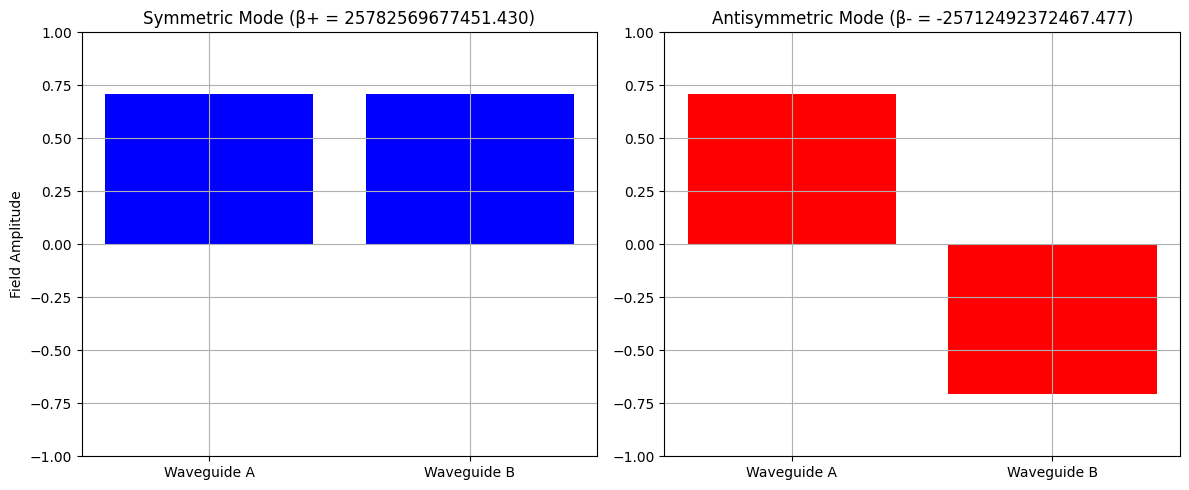

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Field distribution for symmetric mode
ax[0].bar(['Waveguide A', 'Waveguide B'], modes[1, :], color='blue')
ax[0].set_title(f"Symmetric Mode (β+ = {beta_plus:.3f})")
ax[0].set_ylabel("Field Amplitude")
ax[0].set_ylim([-1, 1])
ax[0].grid(True)

# Field distribution for antisymmetric mode
ax[1].bar(['Waveguide A', 'Waveguide B'], modes[0, :], color='red')
ax[1].set_title(f"Antisymmetric Mode (β- = {beta_minus:.3f})")
ax[1].set_ylim([-1, 1])
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [28]:
A_minus = modes[0][0]
B_minus = modes[0][1]
A_plus = modes[1][0]
B_plus = modes[1][1]
# Calculate modes
E_plus = A_plus * E_a(x) + B_plus * E_b(x)
E_minus = A_minus * E_a(x) + B_minus * E_b(x)

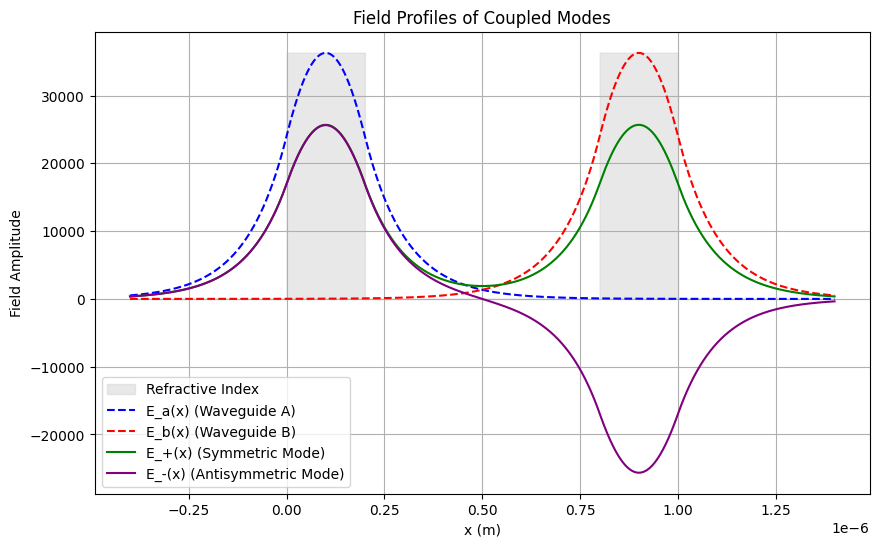

In [29]:
# Plot the profiles
plt.figure(figsize=(10, 6))
plt.fill_between(x, n, color='lightgray', alpha=0.5, label="Refractive Index")
plt.plot(x, E_a(x), label="E_a(x) (Waveguide A)", linestyle="dashed", color="blue")
plt.plot(x, E_b(x), label="E_b(x) (Waveguide B)", linestyle="dashed", color="red")
plt.plot(x, E_plus, label="E_+(x) (Symmetric Mode)", color="green")
plt.plot(x, E_minus, label="E_-(x) (Antisymmetric Mode)", color="purple")
plt.title("Field Profiles of Coupled Modes")
plt.xlabel("x (m)")
plt.ylabel("Field Amplitude")
plt.legend()
plt.grid()
plt.show()
